# Forecasting Weekly Wind Energy Generation in New Zealand
Model - ANN

This notebook addresses:
* RQ1: How well does a ANN model forecast weekly wind energy generation?
* RQ2: Does incorporating weekly-aggregated climate variables into ANN improve forecasting accuracy?

The analysis uses weekly sumed and weekly averaged NASA climate data, aligned with operational wind generation data.

In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import itertools
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Dense, Dropout, BatchNormalization, LeakyReLU
from sklearn.preprocessing import MinMaxScaler , StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error , root_mean_squared_error , mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [3]:
all_poc_data = pd.read_csv('EDA_Wind_all_nsp.csv')

In [4]:
all_poc_data

,Fuel_Code,POC_Code,DATE,Total_TP,Island,Latitude,Longitude,PS,T2M,WD50M,WD50M_rad,u,v,WS50M
0,Wind,BPE0331,2015-03-01,472971.4800,NI,-40.280614,175.640510,99.50,18.88,302.2,5.274385,0.532876,-0.846193,5.89
1,Wind,BPE0331,2015-03-02,119485.1800,NI,-40.280614,175.640510,99.39,18.43,304.9,5.321509,0.572146,-0.820152,6.52
2,Wind,BPE0331,2015-03-03,173416.5861,NI,-40.280614,175.640510,99.24,18.92,302.8,5.284857,0.541708,-0.840567,5.08
3,Wind,BPE0331,2015-03-04,127370.3811,NI,-40.280614,175.640510,98.90,18.34,315.5,5.506514,0.713250,-0.700909,4.19
4,Wind,BPE0331,2015-03-05,59379.3772,NI,-40.280614,175.640510,98.46,19.62,328.2,5.728171,0.849893,-0.526956,3.64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35015,Wind,WWD1103,2025-01-27,443172.0000,NI,-41.295618,174.660496,100.13,15.20,185.2,3.232350,-0.995884,-0.090633,6.37
35016,Wind,WWD1103,2025-01-28,338884.0000,NI,-41.295618,174.660496,101.12,16.11,342.9,5.984734,0.955793,-0.294040,5.59
35017,Wind,WWD1103,2025-01-29,983736.0000,NI,-41.295618,174.660496,100.28,17.92,320.9,5.600762,0.776046,-0.630676,10.59
35018,Wind,WWD1103,2025-01-30,114433.0000,NI,-41.295618,174.660496,100.73,16.00,134.7,2.350959,-0.703395,0.710799,3.85


In [5]:
all_poc_data['DATE'] = pd.to_datetime(all_poc_data['DATE'])

In [6]:
all_poc_data['Fuel_Code'] = all_poc_data['Fuel_Code'].astype(str)

In [7]:
all_poc_data['Island'] = all_poc_data['Island'].astype(str)

In [8]:
print(all_poc_data.dtypes)

Fuel_Code            object
POC_Code             object
DATE         datetime64[ns]
Total_TP            float64
Island               object
Latitude            float64
Longitude           float64
PS                  float64
T2M                 float64
WD50M               float64
WD50M_rad           float64
u                   float64
v                   float64
WS50M               float64
dtype: object


In [9]:
# Check for missing values in each column
missing_values = all_poc_data.isnull().sum()
print(missing_values)

# Optionally, check if there are any missing values at all
if all_poc_data.isnull().values.any():
    print("There are missing values in the DataFrame.")
else:
    print("No missing values found in the DataFrame.")

Fuel_Code    0
POC_Code     0
DATE         0
Total_TP     0
Island       0
Latitude     0
Longitude    0
PS           0
T2M          0
WD50M        0
WD50M_rad    0
u            0
v            0
WS50M        0
dtype: int64
No missing values found in the DataFrame.


In [10]:
# List all column names as an Index object
print(all_poc_data.columns)

Index(['Fuel_Code', 'POC_Code', 'DATE', 'Total_TP', 'Island', 'Latitude',
       'Longitude', 'PS', 'T2M', 'WD50M', 'WD50M_rad', 'u', 'v', 'WS50M'],
      dtype='object')


In [11]:
selected_col_for_wind = ['DATE','Island', 'Total_TP','PS', 'T2M', 'WD50M', 'WD50M_rad', 'u', 'v', 'WS50M']  # Replace with your desired column names

In [12]:
df_wind_daily_all_nsp = all_poc_data[selected_col_for_wind].copy()

In [13]:
print(df_wind_daily_all_nsp.dtypes)

DATE         datetime64[ns]
Island               object
Total_TP            float64
PS                  float64
T2M                 float64
WD50M               float64
WD50M_rad           float64
u                   float64
v                   float64
WS50M               float64
dtype: object


In [14]:
df_wind_daily_all_nsp.head()

,DATE,Island,Total_TP,PS,T2M,WD50M,WD50M_rad,u,v,WS50M
0,2015-03-01,NI,472971.4800,99.50,18.88,302.2,5.274385,0.532876,-0.846193,5.89
1,2015-03-02,NI,119485.1800,99.39,18.43,304.9,5.321509,0.572146,-0.820152,6.52
2,2015-03-03,NI,173416.5861,99.24,18.92,302.8,5.284857,0.541708,-0.840567,5.08
3,2015-03-04,NI,127370.3811,98.90,18.34,315.5,5.506514,0.713250,-0.700909,4.19
4,2015-03-05,NI,59379.3772,98.46,19.62,328.2,5.728171,0.849893,-0.526956,3.64


In [15]:
df_wind_daily_all_nsp.set_index('DATE', inplace=True)

In [16]:
df_wind_daily_all_nsp.head()

,Island,Total_TP,PS,T2M,WD50M,WD50M_rad,u,v,WS50M
DATE,,,,,,,,,
2015-03-01,NI,472971.4800,99.50,18.88,302.2,5.274385,0.532876,-0.846193,5.89
2015-03-02,NI,119485.1800,99.39,18.43,304.9,5.321509,0.572146,-0.820152,6.52
2015-03-03,NI,173416.5861,99.24,18.92,302.8,5.284857,0.541708,-0.840567,5.08
2015-03-04,NI,127370.3811,98.90,18.34,315.5,5.506514,0.713250,-0.700909,4.19
2015-03-05,NI,59379.3772,98.46,19.62,328.2,5.728171,0.849893,-0.526956,3.64


In [17]:
record_counts = df_wind_daily_all_nsp.groupby('Island').size()
print(record_counts)

Island
NI    30876
SI     4144
dtype: int64


In [18]:
# list the column names
print(df_wind_daily_all_nsp.columns.tolist())

['Island', 'Total_TP', 'PS', 'T2M', 'WD50M', 'WD50M_rad', 'u', 'v', 'WS50M']


In [19]:
df_wind_daily_all_nsp

,Island,Total_TP,PS,T2M,WD50M,WD50M_rad,u,v,WS50M
DATE,,,,,,,,,
2015-03-01,NI,472971.4800,99.50,18.88,302.2,5.274385,0.532876,-0.846193,5.89
2015-03-02,NI,119485.1800,99.39,18.43,304.9,5.321509,0.572146,-0.820152,6.52
2015-03-03,NI,173416.5861,99.24,18.92,302.8,5.284857,0.541708,-0.840567,5.08
2015-03-04,NI,127370.3811,98.90,18.34,315.5,5.506514,0.713250,-0.700909,4.19
2015-03-05,NI,59379.3772,98.46,19.62,328.2,5.728171,0.849893,-0.526956,3.64
...,...,...,...,...,...,...,...,...,...
2025-01-27,NI,443172.0000,100.13,15.20,185.2,3.232350,-0.995884,-0.090633,6.37
2025-01-28,NI,338884.0000,101.12,16.11,342.9,5.984734,0.955793,-0.294040,5.59
2025-01-29,NI,983736.0000,100.28,17.92,320.9,5.600762,0.776046,-0.630676,10.59


In [20]:
# 1. Define custom agg: sum for some columns, mean for the rest
agg_dict = {
    'Total_TP':    'sum',
    'PS':          'mean',
    'T2M':         'mean',
    'WS50M':       'mean'
   }

In [21]:
# Perform weekly aggregation grouped by Island
df_wind_weekly = df_wind_daily_all_nsp.groupby([pd.Grouper(freq='W'), 'Island']).agg(agg_dict)

In [22]:
df_wind_weekly.head()

Total_TP          PS        T2M     WS50M
DATE       Island                                               
2015-03-01 NI      5.260841e+06  100.112857  19.091429  5.437143
           SI      6.983304e+05  100.890000  16.700000  6.830000
2015-03-08 NI      2.970966e+07   99.060204  18.372449  7.480408
           SI      2.978269e+06   99.881429  13.911429  6.545714
2015-03-15 NI      1.724348e+07   99.761224  17.476327  4.644694

In [23]:
#North Island specific data
df_wind_weekly_north = df_wind_weekly.xs('NI', level='Island')

In [24]:
print(df_wind_weekly_north.shape)

(519, 4)


In [25]:
#South Island specific data
df_wind_weekly_south = df_wind_weekly.xs('SI', level='Island')

In [26]:
print(df_wind_weekly_south.shape)

(519, 4)


In [27]:
# Check for rows where Total_TP equals 0.0
zero_records = df_wind_weekly[df_wind_weekly['Total_TP'] == 0.0]
print("Number of weekly records with Total_TP equal to 0:", len(zero_records))
print(zero_records)

Number of weekly records with Total_TP equal to 0: 0
Empty DataFrame
Columns: [Total_TP, PS, T2M, WS50M]
Index: []


In [28]:
df_wind_weekly_north_before = df_wind_weekly_north.copy()

In [29]:
# Drop the 2015‑03‑01 and 2025-02-02	 rows , looks incomplete
df_wind_weekly_north = df_wind_weekly_north.drop(index=pd.to_datetime('2015-03-01'))
df_wind_weekly_north = df_wind_weekly_north.drop(index=pd.to_datetime('2025-02-02'))

In [30]:
print(df_wind_weekly_north.shape)

(517, 4)


In [31]:
df_wind_weekly_south_before = df_wind_weekly_south.copy()

In [32]:
# Drop the 2015‑03‑01 and 2025-02-02	 rows , looks incomplete
df_wind_weekly_south = df_wind_weekly_south.drop(index=pd.to_datetime('2015-03-01'))
df_wind_weekly_south = df_wind_weekly_south.drop(index=pd.to_datetime('2025-02-02'))

In [33]:
print(df_wind_weekly_south.shape)

(517, 4)


## North Island Daily

In [35]:
# Add 1 to 2-week lagged climate features
df_wind_weekly_north['TP_lag1w'] = df_wind_weekly_north['Total_TP'].shift(1)
df_wind_weekly_north['T2M_lag1w'] = df_wind_weekly_north['T2M'].shift(1)
df_wind_weekly_north['PS_lag1w'] = df_wind_weekly_north['PS'].shift(1)
df_wind_weekly_north['WS50M_lag1w'] = df_wind_weekly_north['WS50M'].shift(1)
df_wind_weekly_north['WS50M_lag2w'] = df_wind_weekly_north['WS50M'].shift(2)
df_wind_weekly_north['WS50M_EWMA'] = df_wind_weekly_north['WS50M'].ewm(alpha=0.3, adjust=False).mean()
#df_hydro_weekly_north['APIxGWETPROF'] = df_hydro_weekly_north['PRECIP_EWMA'] * df_hydro_weekly_north['GWETPROF']

In [36]:
print(df_wind_weekly_north.columns.tolist())

['Total_TP', 'PS', 'T2M', 'WS50M', 'TP_lag1w', 'T2M_lag1w', 'PS_lag1w', 'WS50M_lag1w', 'WS50M_lag2w', 'WS50M_EWMA']


In [37]:
# Retain only lagged + target, drop NA
df_wind_weekly_lagged_north = df_wind_weekly_north[['Total_TP', 'PS', 'T2M', 'WS50M', 'TP_lag1w', 'T2M_lag1w', 'PS_lag1w', 'WS50M_lag1w', 'WS50M_lag2w', 'WS50M_EWMA']].dropna()
df_wind_weekly_lagged_north.head()

,Total_TP,PS,T2M,WS50M,TP_lag1w,T2M_lag1w,PS_lag1w,WS50M_lag1w,WS50M_lag2w,WS50M_EWMA
DATE,,,,,,,,,,
2015-03-22,2.317096e+07,99.580612,13.854694,7.118980,1.724348e+07,17.476327,99.761224,4.644694,7.480408,6.776480
2015-03-29,2.053256e+07,99.906531,16.650408,5.629796,2.317096e+07,13.854694,99.580612,7.118980,4.644694,6.432474
2015-04-05,3.000496e+07,100.376327,16.031224,6.114286,2.053256e+07,16.650408,99.906531,5.629796,7.118980,6.337018
2015-04-12,3.550845e+07,99.678367,16.105510,8.142449,3.000496e+07,16.031224,100.376327,6.114286,5.629796,6.878647
2015-04-19,2.991374e+07,99.568980,11.181837,7.519388,3.550845e+07,16.105510,99.678367,8.142449,6.114286,7.070869


In [38]:
#   Set seeds for reproducibility  
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [39]:
df_wind_weekly_lagged_north.head()

,Total_TP,PS,T2M,WS50M,TP_lag1w,T2M_lag1w,PS_lag1w,WS50M_lag1w,WS50M_lag2w,WS50M_EWMA
DATE,,,,,,,,,,
2015-03-22,2.317096e+07,99.580612,13.854694,7.118980,1.724348e+07,17.476327,99.761224,4.644694,7.480408,6.776480
2015-03-29,2.053256e+07,99.906531,16.650408,5.629796,2.317096e+07,13.854694,99.580612,7.118980,4.644694,6.432474
2015-04-05,3.000496e+07,100.376327,16.031224,6.114286,2.053256e+07,16.650408,99.906531,5.629796,7.118980,6.337018
2015-04-12,3.550845e+07,99.678367,16.105510,8.142449,3.000496e+07,16.031224,100.376327,6.114286,5.629796,6.878647
2015-04-19,2.991374e+07,99.568980,11.181837,7.519388,3.550845e+07,16.105510,99.678367,8.142449,6.114286,7.070869


In [40]:
# 2) Data prep (no randomness here, aside from ’shift’ which is deterministic)
df_ann_wind_north_wk = df_wind_weekly_lagged_north[['Total_TP','TP_lag1w']]

In [41]:
df_ann_wind_north_wk.head()

,Total_TP,TP_lag1w
DATE,,
2015-03-22,2.317096e+07,1.724348e+07
2015-03-29,2.053256e+07,2.317096e+07
2015-04-05,3.000496e+07,2.053256e+07
2015-04-12,3.550845e+07,3.000496e+07
2015-04-19,2.991374e+07,3.550845e+07


In [42]:
n_wind_ann     = len(df_ann_wind_north_wk)
split_ann = int(n_wind_ann * 0.8)

train_n_ann = df_ann_wind_north_wk.iloc[:split_ann]
test_n_ann  = df_ann_wind_north_wk.iloc[split_ann:]

X_train = train_n_ann[['TP_lag1w']].values
y_train = train_n_ann['Total_TP'].values.reshape(-1,1)
X_test  = test_n_ann[['TP_lag1w']].values
y_test  = test_n_ann['Total_TP'].values.reshape(-1,1)


In [43]:
# 3) Scaling
scaler_X = MinMaxScaler()
X_train_s = scaler_X.fit_transform(X_train)
X_test_s  = scaler_X.transform(X_test)

scaler_y = MinMaxScaler()
y_train_s = scaler_y.fit_transform(y_train)
# (We hold off on transforming y_test because we want raw y_test for metrics.)

In [44]:
# 4) Build the ANN
model_ann = Sequential([
    Dense(16, activation='relu', input_shape=(1,)),
    Dense(8,  activation='relu'),
    Dense(1)
])
model_ann.compile(optimizer='adam', loss='mse')

C:\Users\nwn86\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [45]:
# 5) Train the ANN (the shuffle order is now deterministic)
history = model_ann.fit(
    X_train_s, y_train_s,
    epochs=100,
    batch_size=16,
    validation_split=0.05,
    verbose=0
)

In [46]:
# 6) Predict & rescale
y_pred_s = model_ann.predict(X_test_s)
y_pred   = scaler_y.inverse_transform(y_pred_s).flatten()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [47]:
# 7) Metrics on raw scale
mae_ann  = mean_absolute_error(y_test.flatten(), y_pred)
rmse_ann = np.sqrt(mean_squared_error(y_test.flatten(), y_pred))
mape_ann = np.mean(np.abs((y_test.flatten() - y_pred) / y_test.flatten())) * 100

print(f"North Island (without regressors) - Wind - ANN - MAE: {mae_ann:.2f}, RMSE: {rmse_ann:.2f}, MAPE: {mape_ann:.2f}%")

North Island (without regressors) - Wind - ANN - MAE: 19554300.14, RMSE: 23627402.89, MAPE: 30.94%


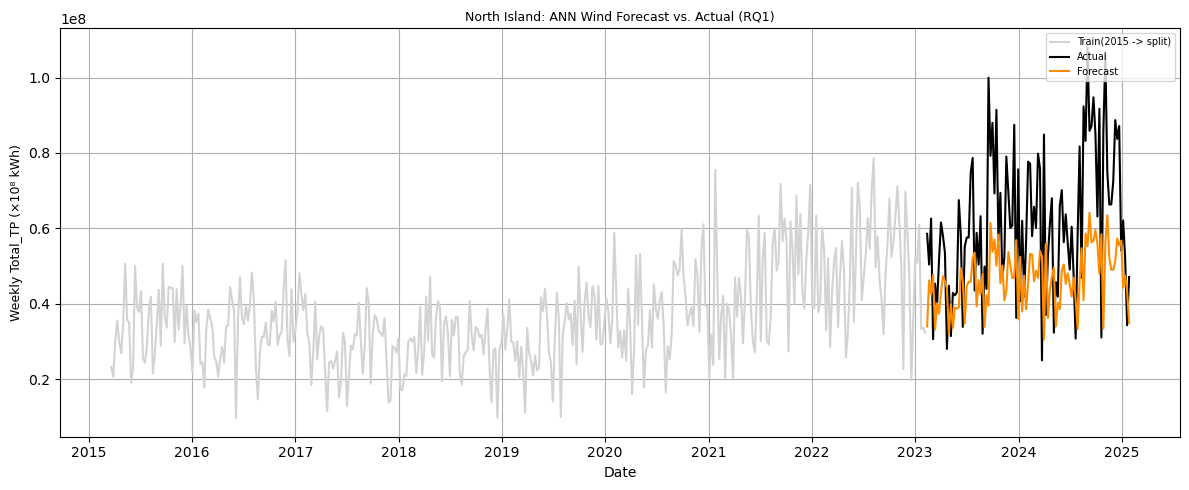

In [48]:
plt.figure(figsize=(12,5))
plt.plot(train_n_ann.index,y_train.flatten(),label="Train(2015 -> split)",color="lightgray")
plt.plot(test_n_ann.index, y_test, label="Actual",   color="black")
plt.plot(test_n_ann.index, y_pred, label="Forecast",      color="darkorange")
plt.title("North Island: ANN Wind Forecast vs. Actual (RQ1)" , fontsize=9)
plt.xlabel("Date")
plt.ylabel("Weekly Total_TP (×10⁸ kWh)",  fontsize=9)
plt.legend(loc="upper right", fontsize=7)
plt.grid(True)
plt.tight_layout()
plt.show()

In [49]:
df_wind_weekly_lagged_north.head()

,Total_TP,PS,T2M,WS50M,TP_lag1w,T2M_lag1w,PS_lag1w,WS50M_lag1w,WS50M_lag2w,WS50M_EWMA
DATE,,,,,,,,,,
2015-03-22,2.317096e+07,99.580612,13.854694,7.118980,1.724348e+07,17.476327,99.761224,4.644694,7.480408,6.776480
2015-03-29,2.053256e+07,99.906531,16.650408,5.629796,2.317096e+07,13.854694,99.580612,7.118980,4.644694,6.432474
2015-04-05,3.000496e+07,100.376327,16.031224,6.114286,2.053256e+07,16.650408,99.906531,5.629796,7.118980,6.337018
2015-04-12,3.550845e+07,99.678367,16.105510,8.142449,3.000496e+07,16.031224,100.376327,6.114286,5.629796,6.878647
2015-04-19,2.991374e+07,99.568980,11.181837,7.519388,3.550845e+07,16.105510,99.678367,8.142449,6.114286,7.070869


In [50]:
print(df_wind_weekly_lagged_north.columns.tolist())

['Total_TP', 'PS', 'T2M', 'WS50M', 'TP_lag1w', 'T2M_lag1w', 'PS_lag1w', 'WS50M_lag1w', 'WS50M_lag2w', 'WS50M_EWMA']


In [51]:
#exog_cols = ['WS50M', 'TP_lag1w']

In [52]:
#factors = ['WS50M', 'TP_lag1w']
# factors = ['WS50M_EWMA']
factors = ['WS50M', 'TP_lag1w','WS50M_EWMA']

In [53]:
# 2) Split via slicing
n = len(df_wind_weekly_lagged_north)
split_idx = int(n * 0.8)

train_df = df_wind_weekly_lagged_north.iloc[:split_idx]
test_df  = df_wind_weekly_lagged_north.iloc[split_idx:]

# 3) Extract raw X and y for train/test
X_train_raw = train_df[factors].values
X_test_raw  = test_df[factors].values
y_train_raw = train_df['Total_TP'].values.reshape(-1, 1)
y_test_raw  = test_df['Total_TP'].values.reshape(-1, 1)

In [54]:
# 4) Scale
x_scaler = StandardScaler().fit(X_train_raw)
y_scaler = StandardScaler().fit(y_train_raw)

X_train = x_scaler.transform(X_train_raw)
X_test  = x_scaler.transform(X_test_raw)
y_train = y_scaler.transform(y_train_raw)
y_test  = y_scaler.transform(y_test_raw)

In [55]:
# 5) Sanity‐check shapes
print(X_train.shape, y_train.shape)
print(X_test.shape,  y_test.shape)

(412, 3) (412, 1)
(103, 3) (103, 1)


In [56]:
# optimizer with clipping & lower LR
opt = tf.keras.optimizers.Adam(learning_rate=5e-4, clipnorm=1.0)

In [57]:
# #model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model = Sequential([
    Dense(128, input_shape=(X_train.shape[1],)),  # start with 64 neurons
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dropout(0.2),

    Dense(64),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dropout(0.2),

    Dense(32),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),

    Dense(1)  # linear output for regression
])

C:\Users\nwn86\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\nwn86\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [58]:
model.compile(
    optimizer=opt,
    loss=Huber(delta=0.5),
    metrics=[tf.keras.metrics.MeanAbsolutePercentageError(name='mape')]
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]

In [59]:
# ── 5) Train (use 10% of train_df as internal validation, keep test_df fully unseen) ──
history = model.fit(
    X_train, y_train,
    validation_split=0.10,  # 10% of training for validation
    epochs=200,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.3563 - mape: 337.1682 - val_loss: 0.5303 - val_mape: 95.7793 - learning_rate: 5.0000e-04
Epoch 2/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2009 - mape: 277.8963 - val_loss: 0.4854 - val_mape: 97.2012 - learning_rate: 5.0000e-04
Epoch 3/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1904 - mape: 261.9849 - val_loss: 0.4830 - val_mape: 95.8923 - learning_rate: 5.0000e-04
Epoch 4/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1761 - mape: 212.4400 - val_loss: 0.4772 - val_mape: 99.6821 - learning_rate: 5.0000e-04
Epoch 5/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1758 - mape: 330.2200 - val_loss: 0.4735 - val_mape: 102.3145 - learning_rate: 5.0000e-04
Epoch 6/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1480 - mape: 211.1255 - val_loss: 0.4705 - val_mape: 103.2370 - learning_rate: 5.0000e-04
Epoch 7/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1624 - mape: 232.9173 - val_loss: 0.

In [60]:
# 1) Predict & inverse‑scale
y_pred_s = model.predict(X_test)
y_pred = y_scaler.inverse_transform(y_pred_s).ravel()
y_true = y_scaler.inverse_transform(y_test).ravel()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


In [61]:
# 2) Metrics
mae  = mean_absolute_error(y_true, y_pred)
#rmse = mean_squared_error(y_true, y_pred, squared=False)
rmse = root_mean_squared_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred) * 100
# print("\nRQ2‐ANN Performance - Hydro (South Island):")
# print(f"MAE : {mae:,.2f}")
# print(f"RMSE: {rmse:,.2f}")
# print(f"MAPE: {mape:.2f}%")
print(f"RQ2: North Island (with regressors) - Wind - ANN - MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")

RQ2: North Island (with regressors) - Wind - ANN - MAE: 14594292.50, RMSE: 17475830.76, MAPE: 23.40%


In [62]:
# factors = ['WS50M', 'TP_lag1w']
# RQ2‐ANN Performance - Hydro (South Island):
# MAE : 18,033,781.28
# RMSE: 21,014,915.23
# MAPE: 28.48%


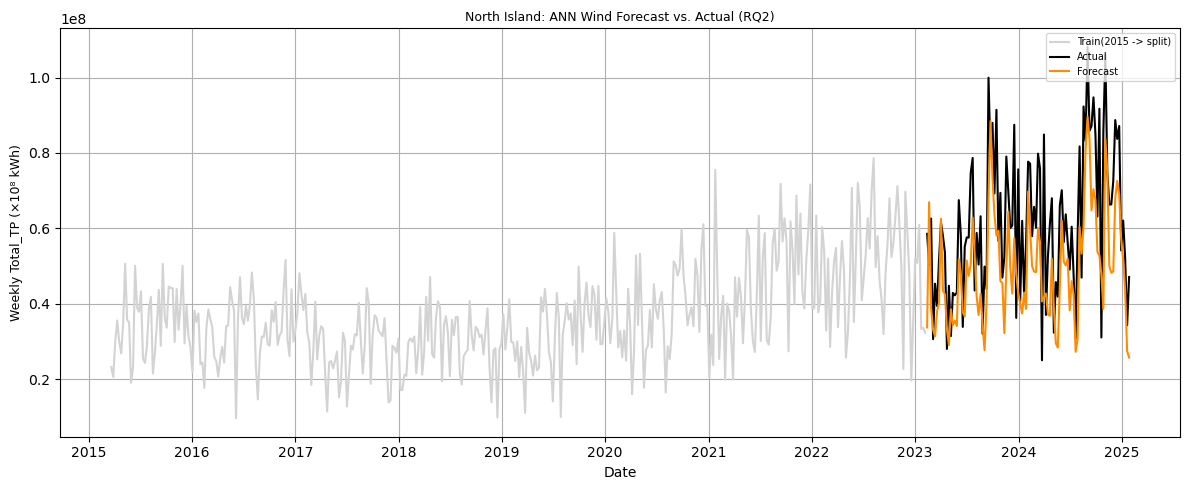

In [123]:
# 11) Plot Train, Test Actuals, and RQ2‐ANN Forecast
plt.figure(figsize=(12, 5))
# 11a) Training‐period actuals (2015 to split)
plt.plot(train_df.index, y_train_raw.flatten(),label="Train(2015 -> split)",color="lightgray")
# 11b) Test‐period actuals
plt.plot(test_df.index,y_test_raw.flatten(),label="Actual",   color="black")
# 11c) RQ2‐ANN forecast over test period
plt.plot(test_df.index,y_pred,label="Forecast",      color="darkorange")
plt.title("North Island: ANN Wind Forecast vs. Actual (RQ2)" , fontsize=9)
plt.xlabel("Date")
plt.ylabel("Weekly Total_TP (×10⁸ kWh)",  fontsize=9)
plt.grid(True)
plt.legend(loc="upper right", fontsize=7)
plt.tight_layout()
plt.show()

## End Noth Island

# South Island 

In [131]:
df_wind_weekly_south.head()

,Total_TP,PS,T2M,WS50M
DATE,,,,
2015-03-08,2.978269e+06,99.881429,13.911429,6.545714
2015-03-15,2.755933e+06,101.075714,13.817143,4.945714
2015-03-22,2.169076e+06,101.260000,11.324286,5.302857
2015-03-29,1.893987e+06,100.988571,13.421429,3.867143
2015-04-05,4.960861e+06,101.465714,13.738571,7.328571


In [133]:
# Add 1 to 2-week lagged climate features
df_wind_weekly_south['TP_lag1w'] = df_wind_weekly_south['Total_TP'].shift(1)
df_wind_weekly_south['T2M_lag1w'] = df_wind_weekly_south['T2M'].shift(1)
df_wind_weekly_south['PS_lag1w'] = df_wind_weekly_south['PS'].shift(1)
df_wind_weekly_south['WS50M_lag1w'] = df_wind_weekly_south['WS50M'].shift(1)
df_wind_weekly_south['WS50M_lag2w'] = df_wind_weekly_south['WS50M'].shift(2)
df_wind_weekly_south['WS50M_EWMA'] = df_wind_weekly_south['WS50M'].ewm(alpha=0.3, adjust=False).mean()
#df_hydro_weekly_north['APIxGWETPROF'] = df_hydro_weekly_north['PRECIP_EWMA'] * df_hydro_weekly_north['GWETPROF']

In [135]:
# Retain only lagged + target, drop NA
df_wind_weekly_lagged_south = df_wind_weekly_south[['Total_TP', 'PS', 'T2M', 'WS50M', 'TP_lag1w', 'T2M_lag1w', 'PS_lag1w', 'WS50M_lag1w', 'WS50M_lag2w', 'WS50M_EWMA']].dropna()
df_wind_weekly_lagged_south.head()

,Total_TP,PS,T2M,WS50M,TP_lag1w,T2M_lag1w,PS_lag1w,WS50M_lag1w,WS50M_lag2w,WS50M_EWMA
DATE,,,,,,,,,,
2015-03-22,2.169076e+06,101.260000,11.324286,5.302857,2.755933e+06,13.817143,101.075714,4.945714,6.545714,5.836857
2015-03-29,1.893987e+06,100.988571,13.421429,3.867143,2.169076e+06,11.324286,101.260000,5.302857,4.945714,5.245943
2015-04-05,4.960861e+06,101.465714,13.738571,7.328571,1.893987e+06,13.421429,100.988571,3.867143,5.302857,5.870731
2015-04-12,2.796316e+06,100.537143,11.622857,7.647143,4.960861e+06,13.738571,101.465714,7.328571,3.867143,6.403655
2015-04-19,2.640676e+06,101.004286,9.812857,7.208571,2.796316e+06,11.622857,100.537143,7.647143,7.328571,6.645130


In [137]:
# 2) Data prep (no randomness here, aside from ’shift’ which is deterministic)
df_ann_wind_south_wk = df_wind_weekly_lagged_south[['Total_TP','TP_lag1w']]

In [139]:
s_hydro_ann     = len(df_ann_wind_south_wk)
split_ann = int(s_hydro_ann * 0.8)

train_s_ann = df_ann_wind_south_wk.iloc[:split_ann]
test_s_ann  = df_ann_wind_south_wk.iloc[split_ann:]

X_train = train_s_ann[['TP_lag1w']].values
y_train = train_s_ann['Total_TP'].values.reshape(-1,1)
X_test  = test_s_ann[['TP_lag1w']].values
y_test  = test_s_ann['Total_TP'].values.reshape(-1,1)

In [141]:
# 3) Scaling
scaler_X = MinMaxScaler()
X_train_s = scaler_X.fit_transform(X_train)
X_test_s  = scaler_X.transform(X_test)

scaler_y = MinMaxScaler()
y_train_s = scaler_y.fit_transform(y_train)
# (We hold off on transforming y_test because we want raw y_test for metrics.)

In [143]:
# 4) Build the ANN
model_ann_s = Sequential([
    Dense(16, activation='relu', input_shape=(1,)),
    Dense(8,  activation='relu'),
    Dense(1)
])
model_ann_s.compile(optimizer='adam', loss='mse')

C:\Users\nwn86\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [145]:
# 5) Train the ANN (the shuffle order is now deterministic)
history_s = model_ann_s.fit(
    X_train_s, y_train_s,
    epochs=100,
    batch_size=16,
    validation_split=0.05,
    verbose=0
)

In [146]:
# 6) Predict & rescale
y_pred_s = model_ann_s.predict(X_test_s)
y_pred   = scaler_y.inverse_transform(y_pred_s).flatten()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


In [147]:
# 7) Metrics on raw scale
mae_ann  = mean_absolute_error(y_test.flatten(), y_pred)
rmse_ann = np.sqrt(mean_squared_error(y_test.flatten(), y_pred))
mape_ann = np.mean(np.abs((y_test.flatten() - y_pred) / y_test.flatten())) * 100

# print(f"Univariate ANN : South Island - MAE: {mae_ann:.2f}, RMSE: {rmse_ann:.2f}, MAPE: {mape_ann:.2f}%")
print(f"South Island (without regressors) - Wind - ANN - MAE: {mae_ann:.2f}, RMSE: {rmse_ann:.2f}, MAPE: {mape_ann:.2f}%")

South Island (without regressors) - Wind - ANN - MAE: 1758670.67, RMSE: 2301689.43, MAPE: 45.76%


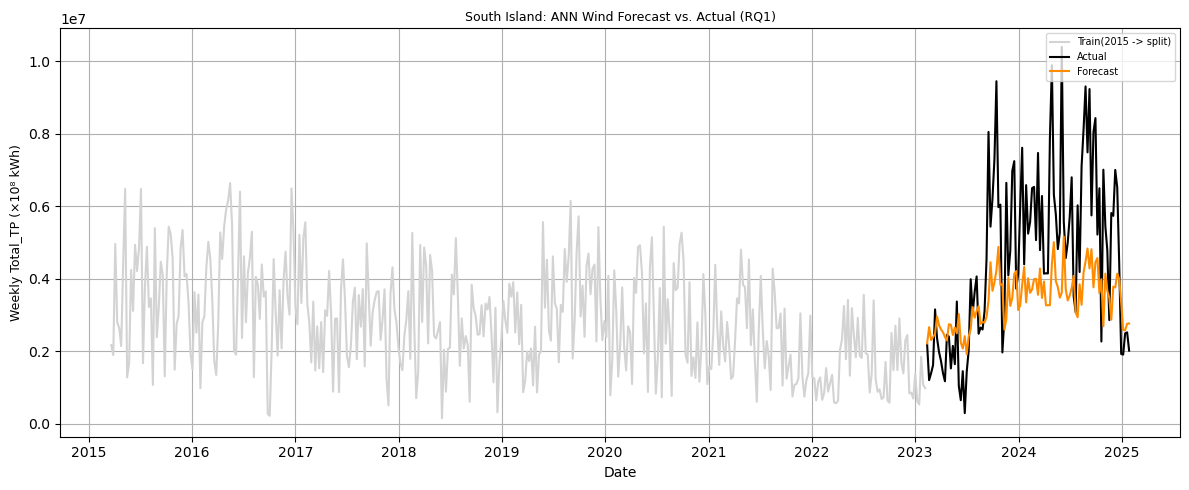

In [151]:
plt.figure(figsize=(12,5))
plt.plot(train_s_ann.index,y_train.flatten(),label="Train(2015 -> split)",color="lightgray")
plt.plot(test_s_ann.index, y_test, label="Actual",   color="black")
plt.plot(test_s_ann.index, y_pred, label="Forecast",      color="darkorange")
plt.title("South Island: ANN Wind Forecast vs. Actual (RQ1)" , fontsize=9)
plt.xlabel("Date")
plt.ylabel("Weekly Total_TP (×10⁸ kWh)",  fontsize=9)
plt.legend(loc="upper right", fontsize=7)
plt.grid(True)
plt.tight_layout()
plt.show()

## RQ2 Start

In [154]:
# factors = ['WS50M', 'TP_lag1w','PS_lag1w']
# factors = ['WS50M', 'TP_lag1w','WS50M_EWMA']
# factors = ['WS50M_EWMA']
factors = ['WS50M', 'TP_lag1w','WS50M_EWMA']

In [156]:
df_wind_weekly_lagged_south.head()

,Total_TP,PS,T2M,WS50M,TP_lag1w,T2M_lag1w,PS_lag1w,WS50M_lag1w,WS50M_lag2w,WS50M_EWMA
DATE,,,,,,,,,,
2015-03-22,2.169076e+06,101.260000,11.324286,5.302857,2.755933e+06,13.817143,101.075714,4.945714,6.545714,5.836857
2015-03-29,1.893987e+06,100.988571,13.421429,3.867143,2.169076e+06,11.324286,101.260000,5.302857,4.945714,5.245943
2015-04-05,4.960861e+06,101.465714,13.738571,7.328571,1.893987e+06,13.421429,100.988571,3.867143,5.302857,5.870731
2015-04-12,2.796316e+06,100.537143,11.622857,7.647143,4.960861e+06,13.738571,101.465714,7.328571,3.867143,6.403655
2015-04-19,2.640676e+06,101.004286,9.812857,7.208571,2.796316e+06,11.622857,100.537143,7.647143,7.328571,6.645130


In [158]:
print(df_wind_weekly_lagged_south.columns.tolist())

['Total_TP', 'PS', 'T2M', 'WS50M', 'TP_lag1w', 'T2M_lag1w', 'PS_lag1w', 'WS50M_lag1w', 'WS50M_lag2w', 'WS50M_EWMA']


In [160]:
# df_wind_weekly_lagged_south['PS_lag1wx_WS50M'] = df_wind_weekly_lagged_south['PS_lag1w'] * df_wind_weekly_lagged_south['WS50M']

In [162]:
# 2) Split via slicing
n = len(df_wind_weekly_lagged_south)
split_idx = int(n * 0.8)

train_df = df_wind_weekly_lagged_south.iloc[:split_idx]
test_df  = df_wind_weekly_lagged_south.iloc[split_idx:]

# 3) Extract raw X and y for train/test
X_train_raw = train_df[factors].values  # (n_samples, n_features)
X_test_raw  = test_df[factors].values
y_train_raw = train_df['Total_TP'].values.reshape(-1, 1)
y_test_raw  = test_df['Total_TP'].values.reshape(-1, 1) # (n_samples, 1)

In [164]:
# 4) Scale
x_scaler = StandardScaler().fit(X_train_raw)
y_scaler = StandardScaler().fit(y_train_raw)

X_train = x_scaler.transform(X_train_raw)
X_test  = x_scaler.transform(X_test_raw)
y_train = y_scaler.transform(y_train_raw)
y_test  = y_scaler.transform(y_test_raw)

In [166]:
# 5) Sanity‐check shapes
print(X_train.shape, y_train.shape)
print(X_test.shape,  y_test.shape)

(412, 3) (412, 1)
(103, 3) (103, 1)


In [168]:
# optimizer with clipping & lower LR
opt = tf.keras.optimizers.Adam(learning_rate=5e-4, clipnorm=1.0)

In [170]:
#   ANN Model  
model = Sequential([
    Dense(128, input_shape=(X_train.shape[1],)),  # start with 64 neurons
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dropout(0.2),

    Dense(64),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dropout(0.2),

    Dense(32),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),

    Dense(1)  # linear output for regression
])

#model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mse")

C:\Users\nwn86\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\nwn86\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [172]:
model.compile(
    optimizer=opt,
    loss=Huber(delta=0.5),
    metrics=[tf.keras.metrics.MeanAbsolutePercentageError(name='mape')]
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]

In [174]:
history = model.fit(
    X_train, y_train,
    validation_split=0.10,  # 10% of training for validation
    epochs=200,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.3263 - mape: 5075.5405 - val_loss: 0.2999 - val_mape: 91.6339 - learning_rate: 5.0000e-04
Epoch 2/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2774 - mape: 1938.2155 - val_loss: 0.2873 - val_mape: 92.1960 - learning_rate: 5.0000e-04
Epoch 3/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2507 - mape: 886.5029 - val_loss: 0.2894 - val_mape: 94.5782 - learning_rate: 5.0000e-04
Epoch 4/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2352 - mape: 2053.0366 - val_loss: 0.2981 - val_mape: 97.7412 - learning_rate: 5.0000e-04
Epoch 5/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2399 - mape: 2853.1021 - val_loss: 0.3024 - val_mape: 98.5976 - learning_rate: 5.0000e-04
Epoch 6/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2121 - mape: 4060.5977 - val_loss: 0.3028 - val_mape: 97.8004 - learning_rate: 5.0000e-04
Epoch 7/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2107 - mape: 4524.2251 - val_loss

In [175]:
# 1) Predict & inverse‑scale
y_pred_s = model.predict(X_test)
y_pred = y_scaler.inverse_transform(y_pred_s).ravel()
y_true = y_scaler.inverse_transform(y_test).ravel()



4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


In [176]:
# 2) Metrics
mae  = mean_absolute_error(y_true, y_pred)
#rmse = mean_squared_error(y_true, y_pred, squared=False)
rmse = root_mean_squared_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred) * 100
# print("\nRQ2‐ANN Performance - Wind (South Island):")
# print(f"MAE : {mae:,.2f}")
# print(f"RMSE: {rmse:,.2f}")
# print(f"MAPE: {mape:.2f}%")
print(f"RQ2: South Island (with regressors) - Wind - ANN - MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")

RQ2: South Island (with regressors) - Wind - ANN - MAE: 2090116.63, RMSE: 2518721.21, MAPE: 46.53%


In [180]:
# 64X
# RQ2‐ANN Performance - Wind (South Island):
# MAE : 1,998,118.16
# RMSE: 2,405,874.11
# MAPE: 45.24%

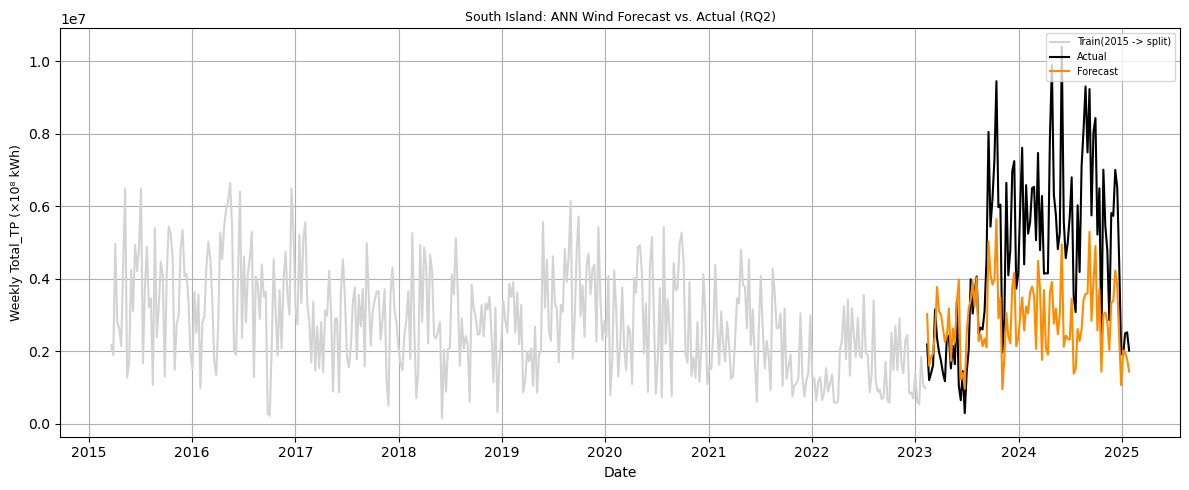

In [182]:
# 11) Plot Train, Test Actuals, and RQ2‐ANN Forecast
plt.figure(figsize=(12, 5))
# 11a) Training‐period actuals (2015 to split)
plt.plot(train_df.index, y_train_raw.flatten(),label="Train(2015 -> split)",color="lightgray")
# 11b) Test‐period actuals
plt.plot(test_df.index,y_test_raw.flatten(),label="Actual",   color="black")
# 11c) RQ2‐ANN forecast over test period
plt.plot(test_df.index,y_pred,label="Forecast", color="darkorange")
plt.title("South Island: ANN Wind Forecast vs. Actual (RQ2)" , fontsize=9)
plt.xlabel("Date")
plt.ylabel("Weekly Total_TP (×10⁸ kWh)",  fontsize=9)
plt.grid(True)
plt.legend(loc="upper right", fontsize=7)
plt.tight_layout()
plt.show()



# plt.figure(figsize=(12,5))
# plt.plot(train_s_ann.index,y_train.flatten(),label="Train(2015 -> split)",color="lightgray")
# plt.plot(test_s_ann.index, y_test, label="Actual",   color="black")
# plt.plot(test_s_ann.index, y_pred, label="Forecast",      color="darkorange")
# plt.title("South Island: ANN Wind Forecast vs. Actual (RQ1)" , fontsize=9)
# plt.xlabel("Date")
# plt.ylabel("Weekly Total_TP (×10⁸ kWh)",  fontsize=9)
# plt.legend(loc="upper right", fontsize=7)
# plt.grid(True)
# plt.tight_layout()
# plt.show()